In [1]:
from snake import Snake as SnakeGame, KeyboardUser as SnakeKeyboardUser
from time import sleep
from IPython.display import clear_output
from graph_tools import get_unique_cycles, reward_per_turn, get_cycles
import numpy as np
import pandas as pd
import random
from functools import reduce, partial
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import types
warnings.filterwarnings('ignore')
%matplotlib inline

# Q-Learning

The premise is a typical reinforcement learning one whereby we have an agent in a stochastic environment where the state is known and where the environment provides the agents with "rewards" for it's actions. The key idea behind Q-learning is to learn a mapping $Q^*(s_t, a_t)$ from states $s_t$ and actions $a_t$ to some value which is referred to as the quality of doing that action in that state. Then when the agent is in some state $s$, with available actions $A$, we define a policy to dictate choosing actions:

$$
    \pi(s) = \arg \max_a P\big(\text{taking action}~a~|~Q^*(s, a)\big)
$$

The probability distribution $P$ can be designed in a variety of ways to promote different behaviour. For example, we could force the agent choose the action with the highest associated $Q$-value, i.e. $P(a~|~Q^*(s, a)= 1$ if $Q^*(s, a) = \max_{a'} Q^*(s, a')$ and zero otherwise, or we could have it behave stochastically such that it occasionally takes actions that it views to be sub-optimal. We may want to encourage the latter kind of behaviour in situations where we believe the agent's $Q$-function to be an inaccurate description for reward generation, thereby the agent will be more inclined to explore the environment and adjust it's model appropriately. On a given timestep $t$ where the agent has recieved reward $r_t$ from taking action $a_t$ in state $s_t$, the adjustment happens by perturbing $Q^*$ according to the update rule:

$$
{\displaystyle Q^*(s_{t},a_{t})\leftarrow (1-\alpha )\cdot \underbrace {Q^*(s_{t},a_{t})} _{\rm {old~value}}+\underbrace {\alpha } _{\rm {learning~rate}}\cdot {\bigg (}\underbrace {r_{t}} _{\rm {reward}}+\underbrace {\gamma } _{\rm {discount~factor}}\cdot \underbrace {V^*(s_{t+1})} _{\rm {estimate~of~optimal~future~value}}{\bigg )}}
$$
The discount factor $\gamma$ serves to tell the agent how much emphasis it should put on future reward $V^*$. Typically we restrain $0 \leq \gamma \leq 1$, due to how after increasing the discount factor beyond one the agent will often deploy very poor or even actively bad strategies. To understand why this happens, consider the term $ r_t + \gamma V^*(s_{t+1}) $ from the $Q$-function update rule and notice how for $\gamma > 1$ the update to the $Q$-function is more effected by $V^*$ than $r_t$, which given how $V^*$ is derived from the agent's pre-existing model means that if said model is erroneous then the bad behavioud can be exponentially reinforced. 

## Simple State Traversal

This "game" lays bare the fundamental nature of $Q$-learning. There are $n$ states $S = \{s_1, \dots, s_n\}$ that the agent can be in. For each state the agent can choose to transition to a select number of other states as defined. A reward function $R : T \rightarrow \mathbb{R}$ is defined for all legal transistions $T \subseteq S^2$. For simplicity, this game is deterministic, however, we will see later that Q-Learners really beat the competition when non-determinism is introduced.

We will encode the $Q$-function as a matrix where $Q_{ij}$ represents the quality being in state $s_i$ and taking the action of transitioning to state $s_j$. In this example the states, legal actions and associated rewards are described by the following graph:

<img src="./state_game.png" width="300px" />

The nodes represent five states; $A$, $B$, $C$, $D$ and $E$, and the edges represent the reward for transitioning between states and the agent will be given a set number or transistions to maximise it's total reward. Notice how the structure of the game gives agents different options for generating reward, with a purposeful local maxima at state $C$. Therefore, we should expect agents with a low emphasis on future reward (i.e. low $\gamma$) to assign the highest quality on continually transitioning from $C$ to $C$. On the other hand, a more intelligent agent should notice that continually moving along the path $A\rightarrow E\rightarrow D\rightarrow B\rightarrow A\rightarrow\dots$ provides a higher net reward per turn.

### Optimal Play:

Given how simple this game is, we can brute force through all possible strategies to find the best one. To do this we use a depth-first search algorithm to find all the cycles in state space and then for each cycle we measure the expected reward gained per turn for constant traversal.

In [2]:
graph = { 'A' : {'E': 120},
          'B' : {'A': -20, 'C': 0, 'D': -100},
          'C' : {'B': -20, 'C': 40, 'D': -100},
          'D' : {'B': 120, 'E': 0},
          'E' : {'D': -20} }

def normalize(cycle):
    n = np.array(list(map(ord, cycle[:-1]))).argmin()
    return ' -> '.join(cycle[n:-1] + cycle[:n] + cycle[n:n+1])

pd.DataFrame([(normalize(c), reward_per_turn(graph, c))
              for c in get_unique_cycles(graph)], 
             columns = ['Cycle', 'Reward Per Turn'])

,Cycle,Reward Per Turn
0,B -> C -> B,-10.000000
1,B -> C -> D -> B,6.666667
2,C -> C,40.000000
3,D -> E -> D,-10.000000
4,A -> E -> D -> B -> A,50.000000
5,B -> D -> B,10.000000


### State Traversal Q-Learner:

The following code implements the state traversal game and agent. The agent will implement a simple Gaussian policy parameterized by an exploration parameter $e$, which serves as the standard deviation for normally distributed variables, such that given the current state $s_c$ we choose the next state $s_n$ based upon,

$$
    s_n = \text{argmax}_{s_i}\{~x_i~:~s_i \in N~\}, \quad\text{where}~ x_i \in \mathcal{N}\big(Q_i,~ e^2\big)
$$

More information about designing this stochastic process is provided in another notebook, however in summary, as the exploration parameter $e$ approaches infinity, the probability of choosing the action with the higher $Q$-value approaches a half. Hence we can control the agents inclination to explore by varying $e$.gained by the move that was just made.

In [3]:
class GeneralStateTraversalGame:
    
    def _transform_graph(self, graph):
        state_to_idx = { s : i for i, s in enumerate(graph.keys()) }
        cvt_options = lambda options : { state_to_idx[end] : reward
                                        for end, reward in options.items() }
        
        self.graph = { state_to_idx[start] : cvt_options(options)
                       for start, options in graph.items() }
        
        self.idx_to_state = dict(enumerate(graph.keys()))
        
    def __init__(self, graph, seed = 0):
        self._transform_graph(graph)
        self.states = list(self.graph.keys())
        self.num_states = len(self.states)
        
        if seed:
            random.seed(seed)
        self.state = random.choice(self.states)
    
    def get_possible_actions(self, from_state = None):
        return list(self.graph[from_state or self.state].keys())
        
    def reward_for_action(self, end_state):
        return self.graph[self.state][end_state]
    
    def go_to(self, next_state):
        self.state = next_state

StateTraversalGame = partial(GeneralStateTraversalGame, graph)
        
class QLearningAgent:
    
    def __init__(self, 
                 game,
                 discount_factor = 0.5,
                 learning_rate = 0.1,
                 exploration_factor = 0):
        
        # core internal state
        self.game = game
        self.q_matrix = np.zeros((game.num_states, game.num_states))
        self.lifetime_reward = 0
        self.t = 0
        
        # learning parameters
        self.lr = learning_rate
        self.df = discount_factor
        self.ef = exploration_factor
        
        # learning records
        self.record = True
        self.q_history = []
        self.reward_history = []
        self.state_history = [self.game.idx_to_state[self.game.state]]
        
    def learning_rate(self, t):
        return self.lr
    
    def discount_factor(self, t):
        return self.df
    
    def exploration_factor(self, t):
        return self.ef
        
    def future_reward_estimate(self, next_state):
        actions = self.game.get_possible_actions(from_state = next_state)
        return self.q_matrix[next_state, actions].max()
        
    def update_q_matrix(self, next_state, reward):
        future_value = self.future_reward_estimate(next_state)
        curr_q = self.q_matrix[self.game.state, next_state]
        
        lr = self.learning_rate(self.t)
        df = self.discount_factor(self.t)
        self.q_matrix[self.game.state, next_state] = \
            (1 - lr) * curr_q + lr * (reward + df * future_value)
    
    def next_state_from_policy(self):
        possible_actions = self.game.get_possible_actions()
        q_values = self.q_matrix[self.game.state, possible_actions]
        ef = self.exploration_factor(self.t)
        if ef > 0:
            rand_vars = [ np.random.normal(loc = q_i, scale = ef)
                          for q_i in q_values ]
            next_state_idx = np.array(rand_vars).argmax()
        else:
            next_state_idx = q_values.argmax()
        return possible_actions[next_state_idx]
    
    def turn(self):
        next_state = self.next_state_from_policy()
        reward = self.game.reward_for_action(next_state)
        self.update_q_matrix(next_state, reward)
        self.game.go_to(next_state)
        
        self.lifetime_reward += reward
        self.t += 1
        
        if self.record:
            self.reward_history += [reward]
            self.q_history += [self.q_matrix.copy()]
            self.state_history += [self.game.idx_to_state[self.game.state]]
    
    def play(self, num_turns = 100, seed = 0):
        if seed:
            np.random.seed(seed)
        for turn in range(num_turns):
            self.turn()

### Evaluation:

With this implementation we can set up a game and run an agent for 1000 timesteps. We discern the "strategy" that a given agent has deployed by comparing the last entries in it's state history to the graph cycles discussed above. To run a game we inject all the aforementioned parameters with the addition of a random seed (for reproducibility) and an exploration decay variable to reduce the exploration factor over time. The intuition here is as the agent has explores more it should become more confident in it's model and start acting more in accordance with it's beliefs. The "decay rate" determines what fraction of the total timesteps should be dedicated to exploring (by default an agent's $e$ value will have decayed to $e=1$ in $T~/~2$ timesteps). 

The first experiment runs for 1000 timesteps and has an exploration parameter of 1000, a learning rate of 0.1 and a discount factor of 0.5. These were chosen semi-arbitrarily, with the exception of ensuring the exploration parameter is large enough to make sure the behaviour is sufficiently varied at the start of the game. Similarly, the learning rate was chosen to ensure the $Q$-values don't blow up too quickly.

In [4]:
def discern_strategy(path, num_cycles = 5):
    cycles = get_cycles(graph)
    def is_strat(s1):
        return s1[:-1]*num_cycles == path[-num_cycles*(len(s1) - 1):]
    strat = reduce(lambda s1, s2 : s1 if is_strat(s1) else s2, 
                   cycles)
    if not is_strat(strat):
        return None
    return normalize(strat)

def play(turns = 1000,   # number of turns 
         ef    = 1000.,  # exploration factor
         dr    = 2.0,    # decay rate 
         lr    = 0.1,    # learning rate
         df    = 0.5,    # discount factor
         seed  = 0,
         Agent = QLearningAgent,
         Game  = StateTraversalGame):
    
    game= Game(seed = seed)
    agent = Agent(game,
                  learning_rate      = lr,
                  discount_factor    = df,
                  exploration_factor = ef)
    
    decay = ef**(-dr / turns)
    def exploration_factor(t):
        return ef * decay ** t
    agent.exploration_factor = exploration_factor
    
    agent.play(num_turns = turns, seed = seed)
    return agent

def game_summary(agent):
    print('Agent\'s end strategy:', 
           discern_strategy(agent.state_history))
    print('Total lifetime reward', agent.lifetime_reward)
    print('Number of turns:', agent.t)
    print('Final Q-matrix:')
    keys = list(graph.keys())
    return pd.DataFrame(agent.q_matrix, 
                        columns = keys, 
                        index = keys)
    
game_summary(play())

Agent's end strategy: C -> C
Total lifetime reward 34800
Number of turns: 1000
Final Q-matrix:


,C,D,B,E,A
C,80.000000,-28.172310,-8.756086,0.000000,0.000000
D,0.000000,0.000000,123.341379,7.973731,0.000000
B,15.000659,-37.203816,0.000000,0.000000,17.330456
E,0.000000,35.584601,0.000000,0.000000,0.000000
A,0.000000,0.000000,0.000000,110.866248,0.000000


We can see that the agent has fallen for the local-maxima trap at $C$, which should be expected for such a low discount factor ($0.5$). To peer deeper we will run 100 trials of this set-up with varying discount factors and count the times that different strategies are deployed. 

In [5]:
def play_games(**kwargs):
    if 'trials' not in kwargs: kwargs['trials'] = 100
    play_kwargs = [(k, v) for k, v in kwargs.items() 
                   if k != 'trials']
    agents = [ play(**dict(play_kwargs + [('seed', s+1)])) 
               for s in range(kwargs['trials']) ]
    return agents

def describe_strategies(agents):
    rewards = [a.lifetime_reward / (a.t + 1) for a in agents]
    strats = [discern_strategy(a.state_history) for a in agents]
    df = pd.DataFrame(np.array([rewards, strats]).transpose(),
                      columns = ['Mean Reward Per Turn', 'Strategy'])
    df = df.convert_objects(convert_numeric = True)
    return df.groupby('Strategy').describe(percentiles = [])

def discount_factor_experiments(discount_factors, **kwargs):
    play_kwargs = lambda df : dict(list(kwargs.items()) + [('df', df)])
    df_experiments = { df : play_games(**play_kwargs(df)) 
                       for df in discount_factors }

    tables  = { 'Discount factor = %.2f' % df : describe_strategies(agents) 
                for df, agents in df_experiments.items() }
    return pd.concat(tables, axis = 1).fillna(0)

def plot_strategies(data_frame, x):
    strats = list(data_frame.index.levels[0])
    plt.figure(figsize = (8, 8))
    x = discount_factors
    last = np.array([ 0.0 for _ in x ])
    for s in strats:
        counts = np.array(data_frame.loc[s].loc['count'])
        means = np.array(data_frame.loc[s].loc['mean'])
        mean = (counts * means).sum() / counts.sum()
        label = 'Strategy = $%s$' % s.replace('->', '\\rightarrow') + \
                '\nMean reward per turn = %.2f\n' % mean
        plt.bar(x, counts, label = label, bottom = last, width = 0.07)
        last += counts
    plt.xlabel('Discount Factor')
    plt.ylabel('Count')
    plt.ylim([0, 105])
    plt.legend(prop = {'size' : 12}, 
               loc='upper left', 
               bbox_to_anchor=(1, 1))
    plt.show()

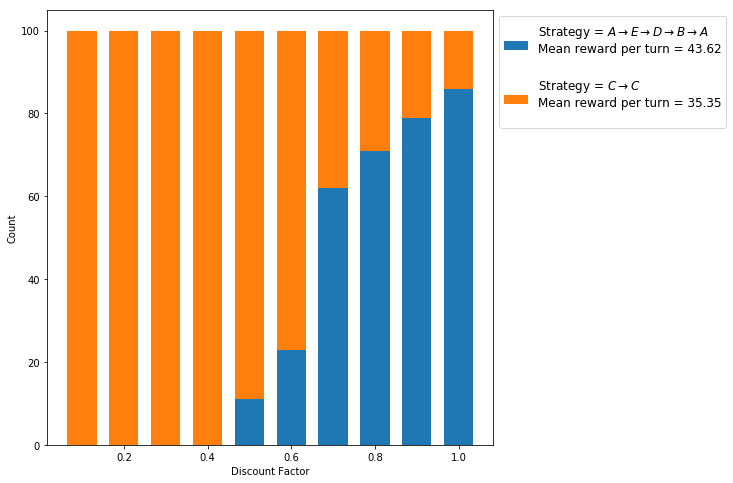

In [51]:
discount_factors = np.arange(0.1, 1.05, 0.1)
data_frame = discount_factor_experiments(discount_factors)
plot_strategies(data_frame, discount_factors)

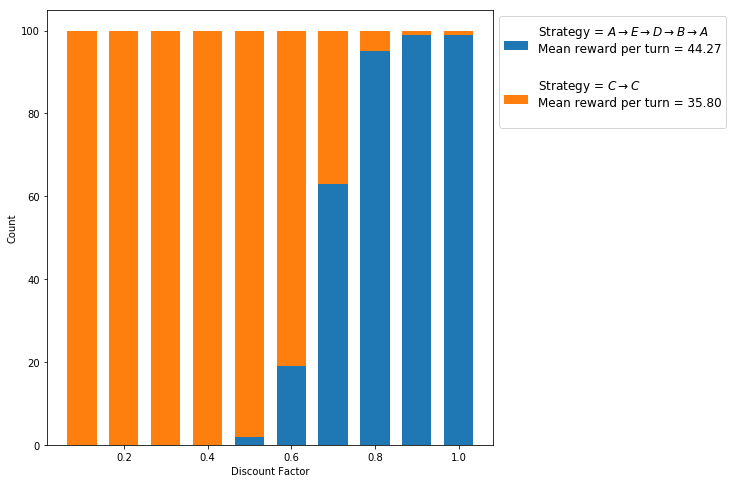

In [53]:
discount_factors = np.arange(0.1, 1.05, 0.1)
data_frame = discount_factor_experiments(discount_factors, turns = 2000)
plot_strategies(data_frame, discount_factors)

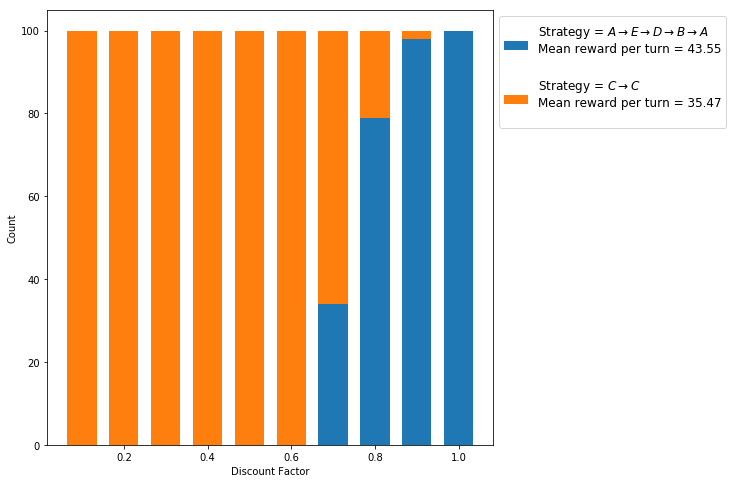

In [80]:
discount_factors = np.arange(0.1, 1.05, 0.1)
data_frame = discount_factor_experiments(discount_factors, turns = 10000, lr = 0.01)
plot_strategies(data_frame, discount_factors)

## Markov Decision Processes

This state traversal game has been a simpler, deterministic form of a Markov decision process (MDP) - the mathematical framework in which a $Q$-learner typically makes decisions within. The main difference is all actions can be performed in any state, and each state-action pair has an associated probability value with each state corresponding to the likelihood of taking the action in one state and transitioning to another. Furthermore, each transition has an associated reward. The following diagram exemplifies this set-up (where no link indicates a zero-probability transition and a no reward arrow indicates zero reward):  

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Markov_Decision_Process.svg/400px-Markov_Decision_Process.svg.png" />

For example, if the agent is in state $s_0$ and takes $a_1$ then it will transition to state $s_2$ with $100\%$ certainty, however, if it's in state $s_1$ and takes action $a_0$ it will transition to $s_0$ $70\%$ of the time, $s_1$ $10\%$ of the time and $s_2$ $20\%$ of the time, and in the case where it transitions to $s_0$ the agent recieve's a reward of $+5$.

## Snake

Snake is a game where an agent has four controls that steer the head of a "snake" in four directions. The snake is composed of a set of continguous cells in two-dimensions. On each timestep the head cell moves in agent-defined direction and the last cell of the tail disapears unless the head cell touches a "berry". This is termed as eating the berry to increase the snake's length; the ultimate goal of the game is to make the snake as long as possible. The game ends when the head of the snake collides with the body. If the head of the snake comes up against the walls of the environment, it wraps around to the opposite edge.

<img src="./snake_screenshot.png", width=300px />

In [2]:
snake = SnakeGame()
user = SnakeKeyboardUser()

try:
    while not snake.is_game_over():
        user.control(snake)
        snake.update()
        sleep(0.1)
        print('Score: %d' % snake.score())
        clear_output(wait = True)
except: pass
finally:
    user.close_game()
print('Game Over. Score: %d' % snake.score())

Game Over. Score: 3500
